# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

# -----------------------------------------------------------------------------------------------------------

## Imports

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import calendar
from sklearn.cluster import KMeans
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
#-------------------------------------------------------------------------------------------------------------------------#
seed = 666

## Preprocess data

In [2]:
data = pd.read_csv('eshop.csv')
data.head(5)

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


In order to be able to sort and subtract dates, I converted the **Date** column to format datetime and consequently sorted it in order to be able to extract the most recent transaction (to be used as current date).

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', ascending=False, inplace=True)

last_transaction = data.iloc[0]['Date']
print(f'Last recorded transaction took place on: {last_transaction}')

Last recorded transaction took place on: 2015-12-19 00:00:00


In order to create the RFM table, I only need the **Customer ID** and **Date** to find *Recency*. The rest of the parameters will be found with the use of the original dataframe.

In [4]:
rfm = data.drop(['Subtotal', 'Country'], axis=1)

### Recency

I only need one record per customer, so I drop duplicate Customer IDs and keep the first ones (because the data is sorted in descending order by **Date**, the first record of a customer is always the most recent one). 

I create a new column for *Recency* which is calculated by taking the date associated with the record (so customer's most recent transaction) and subtracting it from the last recorded transaction which I found above, which gives me the number of days since each customer's last transaction.

At this point, I no longer need the column **Date**, so I drop it.

In [5]:
rfm = rfm.drop_duplicates(subset='Customer ID', keep='first')
rfm['Recency'] = rfm['Date'].apply(lambda x: (last_transaction - x).days)
#rfm['Recency'] = rfm['Date'].apply(lambda x: math.log((last_transaction - x).days + 1))
rfm = rfm.drop(['Date'], axis=1)

### Frequency

I group the customers by their IDs and count the number of records in each group, which gives me the amount of transactions for the given customer. I save this column as *Frequency* and left merge it with the RFM table, which assigns the resulting frequency to its corresponding Customer ID.

In [6]:
counts = data.groupby('Customer ID').count()['Date'].rename('Frequency')
rfm = rfm.merge(counts, how='left', on='Customer ID')

### Monetary

Once again, I group the data by Customer IDs and select the **Subtotal** column, on which I use the aggregation sum() function to get the total spendings of each customer. I name this column *Monetary* and once again merge it with the RFM table, so now each customer has a record of the number of days since their most recent purchase, the number of purchases made by him/her and the total spendings on the eshop.

In [7]:
totals = data.groupby('Customer ID')['Subtotal'].sum().rename('Monetary')#.apply(math.log)
rfm = rfm.merge(totals, how='left', on='Customer ID')

In [8]:
# Function to display several tables in a row next to each other (works in Jupyter, not on Gitlab)
# source: https://www.xspdf.com/help/50899244.html

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+= df.to_html() + '&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp'
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [9]:
display_side_by_side(rfm.sort_values('Recency').tail(15)[['Customer ID', 'Recency']],
                     rfm.sort_values('Frequency').tail(15)[['Customer ID', 'Frequency']],
                     rfm.sort_values('Monetary').tail(15)[['Customer ID', 'Monetary']])

,Customer ID,Recency
12814,166,3013
12815,30,3025
12816,131,3033
12817,96,3042
12818,67,3043
12819,9,3050
12820,62,3054
12821,82,3069
12822,48,3069
12823,78,3073


## K-Means Clustering

In the process of clustering, we will no longer be needing the Customer ID since from subject matter knowledge, we can safely assume that it has no relation to the customers' behaviour.

In [10]:
rfm_km = rfm.drop(['Customer ID'], axis=1)

K-Means clustering requires the parameter *k* to be known before training the model, so I use the Elbow method to try and estimate which *k* value could be the best for this data.

The best *k* value is such, that *k+1* no longer leads to a significant decrease in the loss function. For K-Means, this loss function is **inertia** which is calculated as the average of the within-cluster sum-of-squares. It simply tells us how internally coherent the clusters are.

I iterate over *k_cnt* values of *k*, perform K-Means clusetring with this parameter and calculate the value of inertia. I then plot the respective inertia values against their *k* values and analyze the graph.

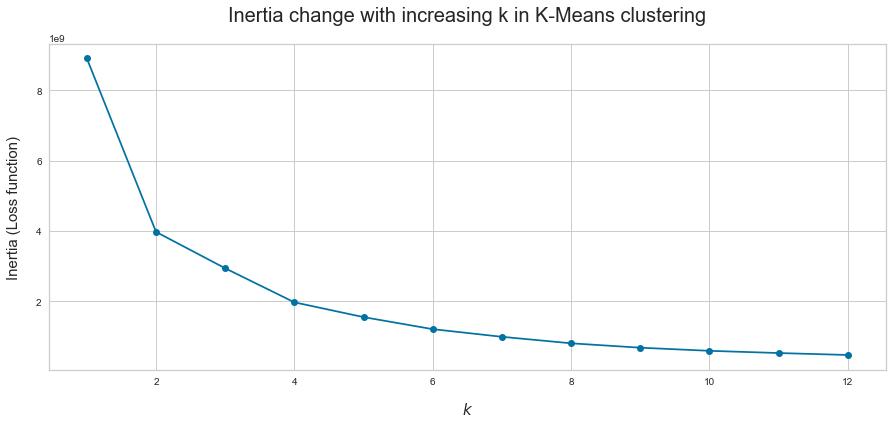

In [11]:
k_cnt = 12

inertias = np.zeros(k_cnt)
for k in range(k_cnt):
    kmeans = KMeans(n_clusters=k+1, random_state=seed)
    kmeans.fit(rfm_km)
    inertias[k] = kmeans.inertia_

plt.figure(figsize=(15,6))
plt.title('Inertia change with increasing k in K-Means clustering', fontsize=20, y=1.05)
plt.xlabel('$k$', fontsize=15, labelpad=15)
plt.ylabel('Inertia (Loss function)', fontsize=15, labelpad=15)
plt.plot(range(1, k_cnt + 1), inertias, 'o-')
plt.show()

Based on this graph, I can tell that the biggest decrease in inertia happens with adding a second cluster, but keeps being significant until reaching roughly the value 5 or 6. That leads me to suspect, that the optimal *k* value for this data will be somewhere around 4 or 5.

In order to test my hypothesis, I use the KElbowVisualizer from the yellowbrick visualization library. The visualizer also analyzes the affect of *k* on the inertia (which it calls distortion score) and saves the value with the strongest inflection point on the curve.

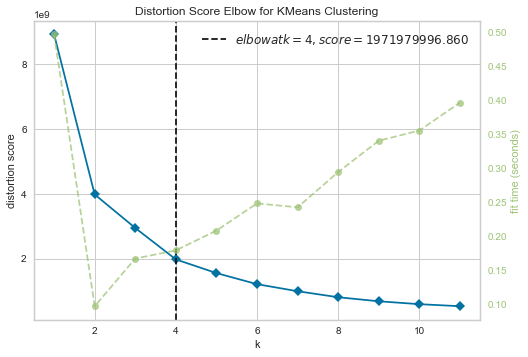

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
model = KMeans(random_state=seed)
visualizer = KElbowVisualizer(model, k=(1,12), metric="distortion")
visualizer.fit(rfm_km)
visualizer.show()

In [13]:
k = visualizer.elbow_value_
print(f'The optimal value of k chosen by the Elbow method with the distortion metric: {k}')

The optimal value of k chosen by the Elbow method with the distortion metric: 4


In [14]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(rfm_km)

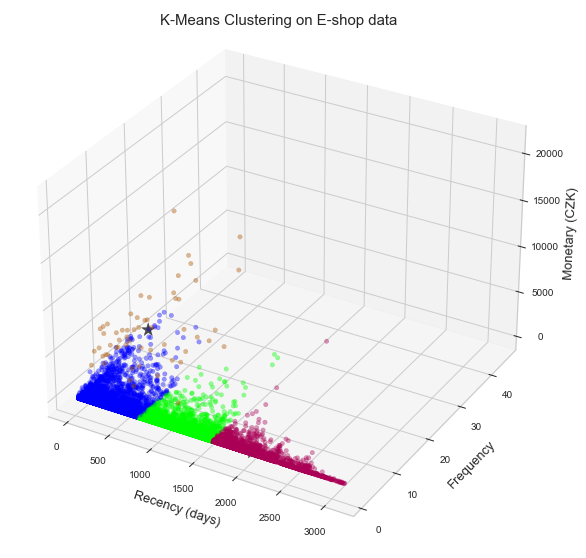

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_km['Recency'], rfm_km['Frequency'], rfm_km['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.7, s=200, marker='*')

ax.set_title('K-Means Clustering on E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency (days)', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary (CZK)', fontsize=13, labelpad=10)
plt.show()

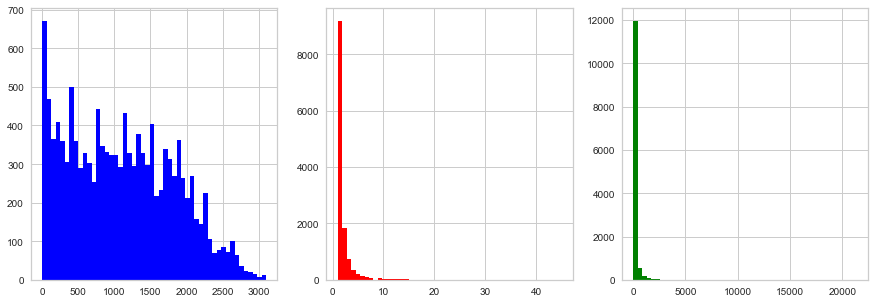

In [16]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].hist(rfm_km['Recency'], bins=50, color='blue')
axes[1].hist(rfm_km['Frequency'], bins=50, color='red')
axes[2].hist(rfm_km['Monetary'], bins=50, color='green')
plt.show()

### Standardization

In [17]:
std_scaler = preprocessing.StandardScaler()
std_rfm = std_scaler.fit_transform(rfm_km)
std_rfm = pd.DataFrame(std_rfm, columns=rfm_km.columns)
std_rfm

,Recency,Frequency,Monetary
0,-1.517677,-0.371483,-0.040975
1,-1.517677,-0.371483,-0.335166
2,-1.516301,-0.371483,0.467084
3,-1.516301,-0.371483,-0.358049
4,-1.516301,-0.371483,-0.205202
...,...,...,...
12824,2.712088,-0.371483,-0.304386
12825,2.721723,-0.371483,-0.364965
12826,2.738240,-0.371483,-0.250919
12827,2.745122,-0.371483,-0.287953


In [18]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(std_rfm)

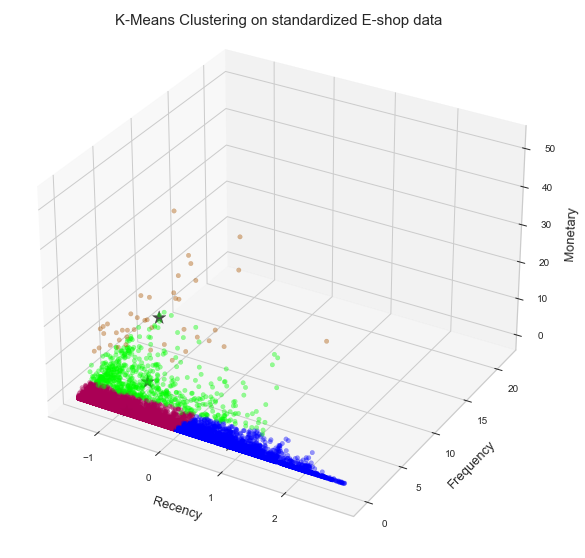

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(std_rfm['Recency'], std_rfm['Frequency'], std_rfm['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.7, s=200, marker='*')

ax.set_title('K-Means Clustering on standardized E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary', fontsize=13, labelpad=10)
plt.show()

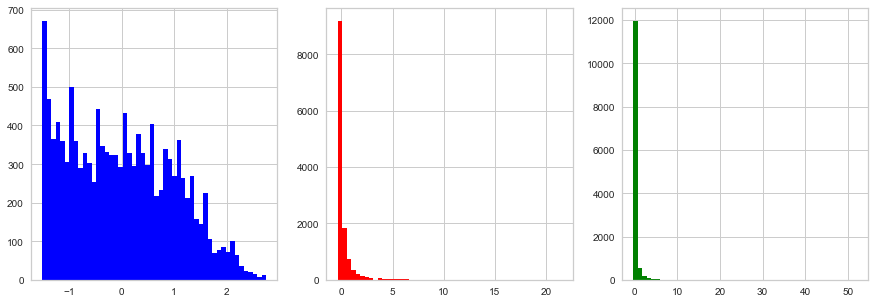

In [20]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].hist(std_rfm['Recency'], bins=50, color='blue')
axes[1].hist(std_rfm['Frequency'], bins=50, color='red')
axes[2].hist(std_rfm['Monetary'], bins=50, color='green')
plt.show()

In [21]:
minmax_scaler = preprocessing.MinMaxScaler()
norm_rfm = minmax_scaler.fit_transform(rfm_km)
norm_rfm = pd.DataFrame(norm_rfm, columns=rfm_km.columns)
norm_rfm

,Recency,Frequency,Monetary
0,0.000000,0.0,0.006448
1,0.000000,0.0,0.000840
2,0.000322,0.0,0.016131
3,0.000322,0.0,0.000404
4,0.000322,0.0,0.003317
...,...,...,...
12824,0.990332,0.0,0.001427
12825,0.992588,0.0,0.000272
12826,0.996455,0.0,0.002446
12827,0.998066,0.0,0.001740


### Normalization

In [22]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(norm_rfm)

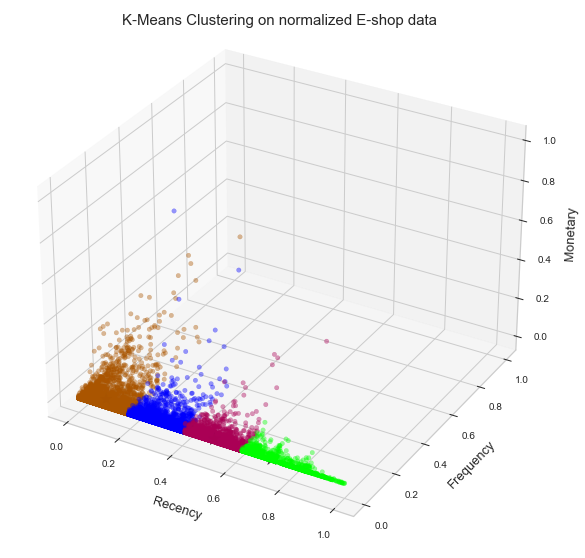

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(norm_rfm['Recency'], norm_rfm['Frequency'], norm_rfm['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.7, s=200, marker='*')

ax.set_title('K-Means Clustering on normalized E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary', fontsize=13, labelpad=10)
plt.show()

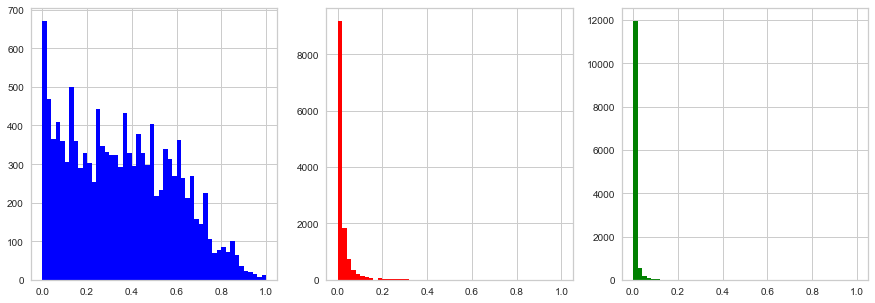

In [24]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].hist(norm_rfm['Recency'], bins=50, color='blue')
axes[1].hist(norm_rfm['Frequency'], bins=50, color='red')
axes[2].hist(norm_rfm['Monetary'], bins=50, color='green')
plt.show()

# -----------------------------------------------------------------------------------------------------------

# Bonus 1

I will try to use Silhouette score analysis of the clusters in order to determine the optimal *k* value for K-Means. 

The Silhouette score of a sample of data is used to describe how dense and well-separated the clusters are. The score ranges from -1 to 1 and reflects the intra-cluster distances among points as well as the inter-cluster distances to the next nearest cluster.

The interpretation of the Silhouette score is as follows:
* 1 - clusters are very dense and well separated
* 0 - there is some overlap among the clusters
* -1 - data belonging to some clusters is wrongly classified

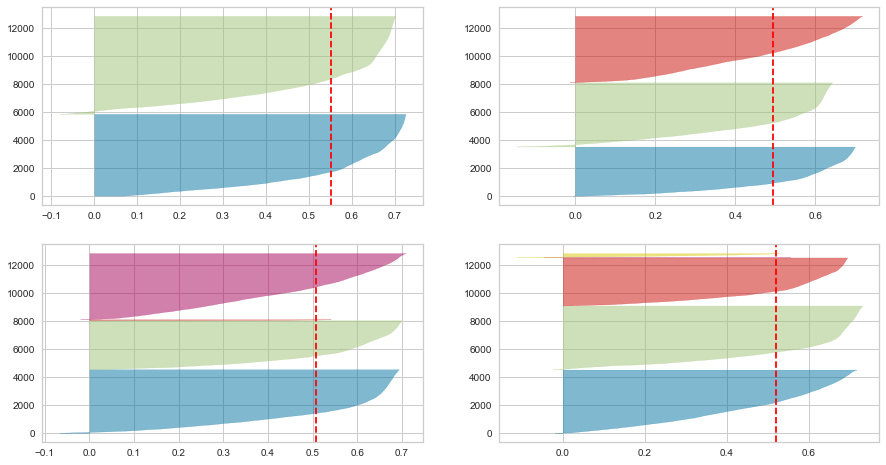

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2, 6):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=seed)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(rfm_km)

Inadequate for several reasons:
* wide fluctuations in size of the silhouette plots
* some clusters scoring below average

n=3 the spread is uniform, scores above average

# -----------------------------------------------------------------------------------------------------------

# Bonus 2

## 2. Preprocess data

In [26]:
rfm2 = data.drop(['Country', 'Subtotal'], axis=1)

### 2. Recency

Like in the previous example, I only need the latest transaction for each customer, so I drop duplicity Customer IDs from the data table sorted by **Date**.

I then proceed to create a *Recency* column in the RFM, which is calculated as the maximum of 1 and the number of months since customer's last purchase. I calculate the number of months by taking the days in the timedelta object and dividing them by 30, so it won't be quite exact, but it is a good enough approximation for our use.

In [27]:
rfm2 = rfm2.drop_duplicates(subset='Customer ID', keep='first')
rfm2['Recency'] = rfm2['Date'].apply(lambda x: max(int((last_transaction - x).days / 30), 1))
rfm2 = rfm2.drop(['Date'], axis=1)

### 2. Frequency

In order to make this expandable for finding clusters of customers generally in the last *x* months, I implemented a function which takes a given date and subtracts a given amount of months from it. 

As per this specific task, I subtract 12 months and then go on to filter the data table to only include records that were recorded after the calculated date. I group these results by their Customer IDs and count the number of such records per each customer. This column is then left merged with the RFM table and named *Frequency*. Those customers, that have made no purchase during the last 12 months now have their *Frequency* set to NaN, so I replace missing values with 1 since that is the maximum of 0 and 1.

In [28]:
def subtract_months(date, delta):
    m = (date.month - delta) % 12
    if date.month - delta < 1:
        y = date.year + ((date.month - delta - 1) // 12)
    else: y = date.year
    if m == 0:
        m = 12
    d = min(date.day, calendar.monthrange(y, m)[1]) # either the same day or the max date in the given month
    return datetime.datetime(y, m, d)

x = last_transaction
assert subtract_months(x, 0) == datetime.datetime(x.year, x.month, x.day)
assert subtract_months(x, 3) == datetime.datetime(x.year, x.month - 3, x.day)
assert subtract_months(x, 12) == datetime.datetime(x.year - 1, x.month, x.day)
assert subtract_months(x, 20) == datetime.datetime(x.year - 1, 4, x.day)
assert subtract_months(x, 169) == datetime.datetime(2001, 11, x.day)
assert subtract_months(datetime.datetime(2020, 7, 31), 1049) == datetime.datetime(1933, 2, 28)

In [29]:
last_year_counts = data[data['Date'] > subtract_months(last_transaction, 12)].groupby('Customer ID').count()['Date'].rename('Frequency')
rfm2 = rfm2.merge(last_year_counts, how='left', on='Customer ID').fillna(1)

### 2. Monetary

I find each customer's maximum purchase in the whole dataset by grouping the records by Customer ID and finding the max() in the aggregation. I name this column *Monetary* and left merge it with the RFM table, which includes one record per each customer.

In [30]:
max_subtotal = data.groupby('Customer ID')['Subtotal'].max().rename('Monetary')
rfm2 = rfm2.merge(max_subtotal, how='left', on='Customer ID')

In [31]:
display_side_by_side(rfm2.sort_values('Recency').tail(15)[['Customer ID', 'Recency']],
                     rfm2.sort_values('Frequency').tail(15)[['Customer ID', 'Frequency']],
                     rfm2.sort_values('Monetary').tail(15)[['Customer ID', 'Monetary']])

,Customer ID,Recency
12814,166,100
12815,30,100
12820,62,101
12819,9,101
12817,96,101
12816,131,101
12818,67,101
12821,82,102
12822,48,102
12823,78,102


## 2. K-Means Clustering

In [32]:
rfm2_km = rfm.drop(['Customer ID'], axis=1)

As previously, I employ the Elbow method in order to determine the optimal *k* value for the K-Means clustering.

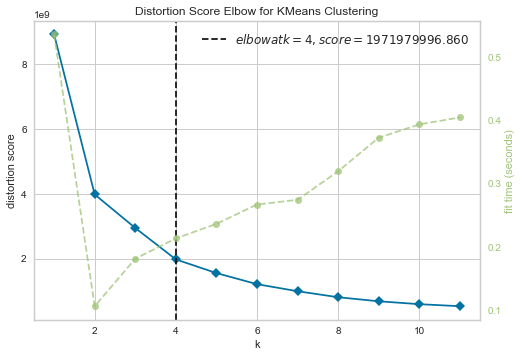

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
model = KMeans(random_state=seed)
visualizer = KElbowVisualizer(model, k=(1,12), metric="distortion")
visualizer.fit(rfm2_km)
visualizer.show()

In [34]:
k = visualizer.elbow_value_
print(f'The optimal value of k chosen by the Elbow method with the distortion metric: {k}')

The optimal value of k chosen by the Elbow method with the distortion metric: 4


In [35]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(rfm2_km)

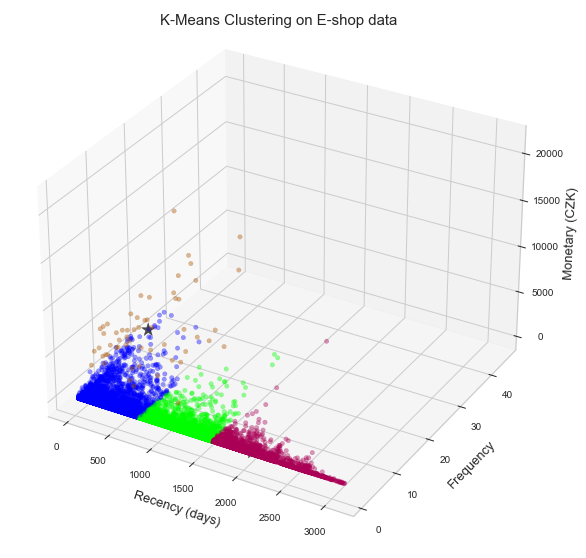

In [36]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm2_km['Recency'], rfm2_km['Frequency'], rfm2_km['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.7, s=200, marker='*')

ax.set_title('K-Means Clustering on E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency (days)', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary (CZK)', fontsize=13, labelpad=10)
plt.show()

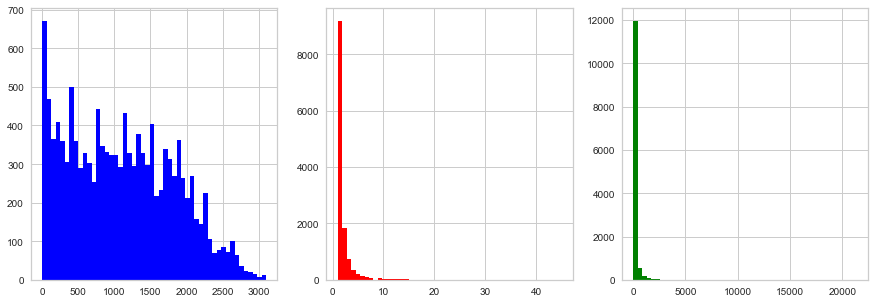

In [37]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].hist(rfm2_km['Recency'], bins=50, color='blue')
axes[1].hist(rfm2_km['Frequency'], bins=50, color='red')
axes[2].hist(rfm2_km['Monetary'], bins=50, color='green')
plt.show()